In [24]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf



mnthly_agg_dta = pd.read_csv('monthly_agg_sales.csv')
mnthly_agg_dta['month'] = pd.to_datetime(mnthly_agg_dta['month'])
mnthly_agg_dta.head()

,Sales,month
0,4851.080,2014-01-01
1,1071.724,2014-02-01
2,8605.879,2014-03-01
3,11155.074,2014-04-01
4,7135.624,2014-05-01


In [13]:
train_df = mnthly_agg_dta[(mnthly_agg_dta['month']) <= '2017-06-01']
train_df.shape

(42, 2)

In [15]:
test_df =  mnthly_agg_dta[(mnthly_agg_dta['month']) > '2017-06-01']                      
test_df.shape

(6, 2)

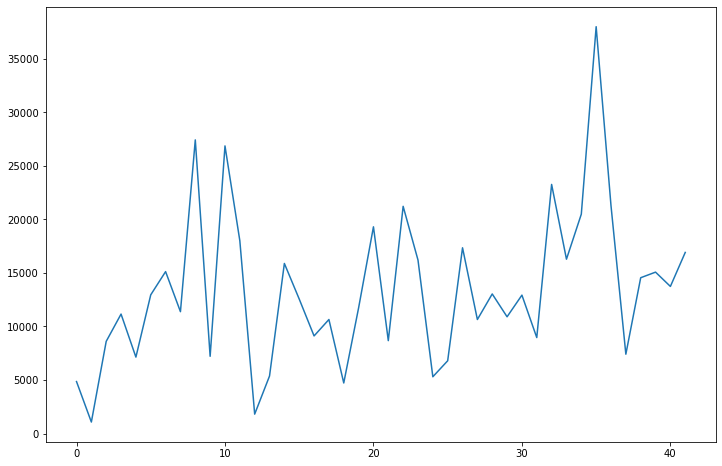

In [16]:
train_df['Sales'].plot(figsize=(12,8))

In [17]:
train_df.set_index('month',inplace = True)
test_df.set_index('month',inplace = True)

In [18]:
result = adfuller(train_df.Sales.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.288990
p-value: 0.000006


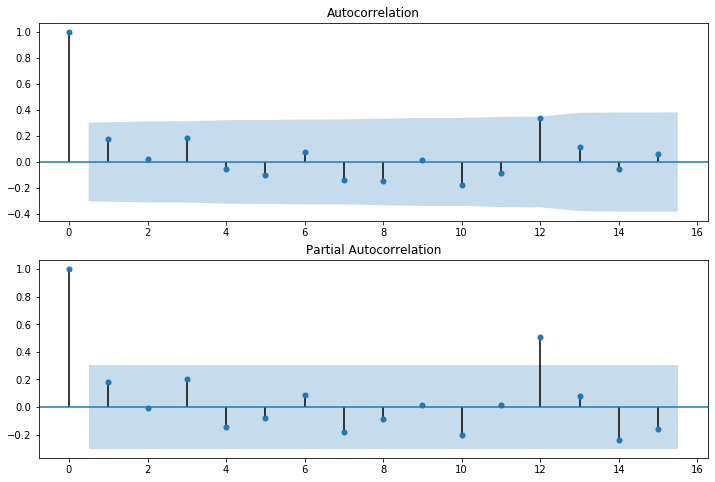

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_df['Sales'].dropna(),lags=15,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_df['Sales'].dropna(),lags=15,ax=ax2)

In [31]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train_df.Sales,order=(1,0,1))
model_fit=model.fit()
model_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   42
Model:                     ARMA(1, 1)   Log Likelihood                -432.191
Method:                       css-mle   S.D. of innovations           7121.146
Date:                Fri, 04 Nov 2022   AIC                            872.382
Time:                        23:24:13   BIC                            879.333
Sample:                    01-01-2014   HQIC                           874.930
                         - 06-01-2017                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         1.33e+04   1472.543      9.031      0.000    1.04e+04    1.62e+04
ar.L1.Sales     0.5280      0.607      0.870      0.385      -0.662       1.718
ma.L1.Sales    -0.3635      0.653     -0.557      0.578      -1.643       0.916
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8940           +0.0000j            1.8940            0.0000
MA.1            2.7508           +0.0000j            2.7508            0.0000
-----------------------------------------------------------------------------
"""

In [32]:
full_data['forecast'] = model_fit.predict(start = 36, end = 48, dynamic = True)
full_data.tail(6)

,Sales,forecast
month,,
2017-07-01,10241.468,13398.704331
2017-08-01,30059.852,13351.452871
2017-09-01,31895.843,13326.505011
2017-10-01,23037.192,13313.333022
2017-11-01,31472.337,13306.378466
2017-12-01,30436.942,13302.706595


In [33]:
test_data = full_data.tail(6)
test_data
test_data['error'] = test_data.Sales - test_data.forecast
mape = np.round(np.mean(np.abs(100*test_data.error/test_data.Sales)), 0)
mape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


50.0

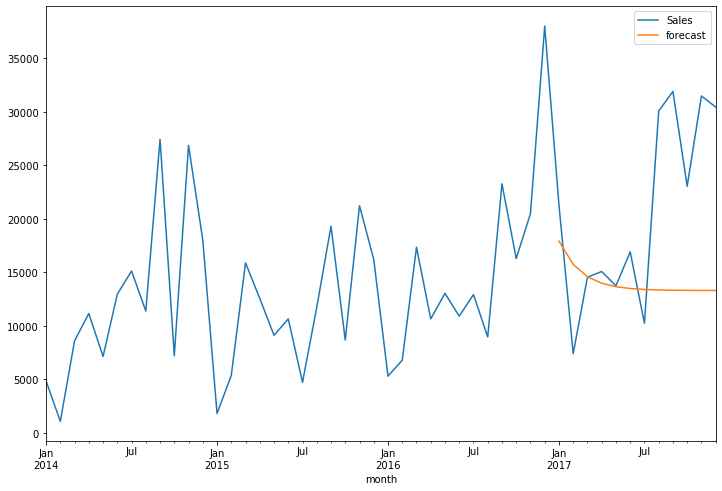

In [34]:
full_data[['Sales','forecast']].plot(figsize = (12,8))

In [ ]:
Can we improve ?

In [35]:
model = sm.tsa.statespace.SARIMAX(train_df.Sales, order=(1,1,1),seasonal_order = (1,1,1,12))
model_fit_seasonal = model.fit()
print(model_fit_seasonal.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -293.627
Date:                            Fri, 04 Nov 2022   AIC                            597.253
Time:                                    23:26:17   BIC                            604.090
Sample:                                01-01-2014   HQIC                           599.394
                                     - 06-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2673      0.486      0.550      0.583      -0.686       1.221
ma.L1         -0.7951      0.310   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


In [36]:
full_data = pd.concat([train_df, test_df], axis=0)
full_data['forecast'] = model_fit_seasonal.predict(start = 36, end = 48, dynamic = True)
full_data.tail(6)

,Sales,forecast
month,,
2017-07-01,10241.468,20562.671179
2017-08-01,30059.852,19958.785405
2017-09-01,31895.843,31433.289783
2017-10-01,23037.192,22199.383962
2017-11-01,31472.337,30465.786504
2017-12-01,30436.942,36566.402230


In [37]:
test_data = full_data.tail(6)
test_data
test_data['error'] = test_data.Sales - test_data.forecast
mape = np.round(np.mean(np.abs(100*test_data.error/test_data.Sales)), 0)
mape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


27.0

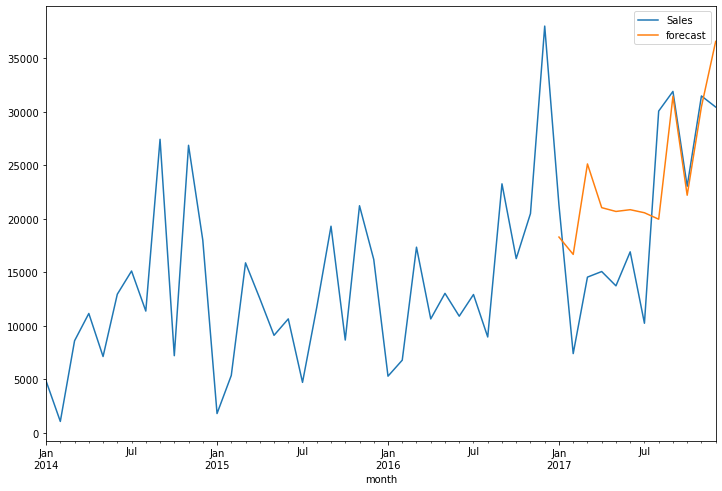

In [38]:
full_data[['Sales','forecast']].plot(figsize = (12,8))

In [44]:
import pandas as pd
sugar_data = pd.read_csv('sugar_cane.csv')
sugar_data.head()

,Time,Yield
0,T1,57.05
1,T2,61.63
2,T3,51.00
3,T4,44.41
4,T5,58.74


In [45]:
sugar_data= sugar_data.set_index('Time')

In [46]:
result = adfuller(sugar_data.Yield.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.815404
p-value: 0.991881


In [48]:
sugar_data_stationary = sugar_data - sugar_data.shift(1) #8
sugar_data_stationary.dropna(inplace=True)

dftest = adfuller(sugar_data_stationary, autolag='AIC')
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])

print (dfoutput)

Test Statistic   -2.026925
p-value           0.274894
dtype: float64
